<a href="https://colab.research.google.com/github/tomasallemand/wvs-democracy-attitudes-ml/blob/main/notebooks/01_wvs_democracy_attitudes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Attitudes Toward Democracy  
World Values Survey – Machine Learning Project

# <mark style="background:#FFF9C4"> ABSTRACT

This project analyzes how people evaluate democracy using World Values Survey (WVS) responses.

The goal is to build a simple, reproducible pipeline that cleans survey data, explores key patterns, and trains a binary classification model to predict **lower vs higher ratings of democracy**, based on other individual attitudes and perceptions.

**Audience:** anyone interested in applied, end-to-end data analysis (EDA + modeling) using real survey data.

# <mark style="background:#FFF9C4"> PROJECT GOAL

Identify which survey variables are most associated with **Q250 (importance of democracy)** and build a predictive model that classifies respondents into **lower vs higher democracy ratings**, using only information available in the survey responses.

# <mark style="background:#FFF9C4"> ANALYTICAL CONTEXT

The dataset used in this project comes from the World Values Survey – Wave 7 (v5.0), a large-scale international survey covering over 200 questions related to socio-political and economic attitudes.

**The survey includes both**:
* Objective variables (e.g., age, income),
* Subjective perceptions (e.g., corruption, institutional trust, political values).

Although most variables are originally categorical, they are encoded as discrete numerical values in the dataset.

Each column is labeled using the format QXXX, where:
Q stands for "question",
The number identifies the specific survey item.

**The dataset contains**:
*  variables
* 1003 respondents

(The high dimensionality of the dataset makes it a suitable case for feature selection and regularized modeling techniques.)

In [1]:
!pip install catboost
!pip install shap
# Librerías:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
import plotly.express as px
import re
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    roc_auc_score
)
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from IPython.display import display
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

import shap
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", message="`js` is deprecated in `shap`.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 8.3 MB/s eta 0:00:00


In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/tomasallemand/wvs-democracy-attitudes-ml/main/data/WVS_FINAL_LIMPIO_7_v5.0.csv',delimiter=";")

In [3]:
df.head()

,version,doi,B_COUNTRY,B_COUNTRY_ALPHA,C_COW_NUM,C_COW_ALPHA,A_YEAR,D_INTERVIEW,J_INTDATE,FW_END,...,WEIGHT4A,WEIGHT4B,RESEMAVALBWGT,RESEMAVALWGT,SECVALBWGT,Y001_1,Y001_2,Y001_3,Y001_4,Y001_5
0,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070001.0,20170709.0,201707.0,...,1.0,1.0,0.83,0.915,1.00,0.0,0.0,0.0,0.0,0.0
1,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070002.0,20170709.0,201707.0,...,1.0,1.0,1.00,1.000,0.83,1.0,1.0,0.0,1.0,1.0
2,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070003.0,20170710.0,201707.0,...,1.0,1.0,1.00,1.000,1.00,0.0,0.0,1.0,0.0,0.0
3,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070004.0,20170710.0,201707.0,...,1.0,1.0,1.00,1.000,1.00,1.0,1.0,0.0,0.0,0.0
4,1-5-0 (2020-11-16),doi.org/10.14281/18241.1,32.0,ARG,160.0,ARG,2017.0,32070005.0,20170710.0,201707.0,...,1.0,1.0,1.00,1.000,1.00,1.0,1.0,0.0,1.0,0.0


In [4]:
# Drop duplicated columns:
columns_to_drop = ['Q34_3','Q33_3','Q35_3',]
df = df.drop(columns=columns_to_drop)

# <mark style="background:#FFF9C4"> DIMENSIONALITY REDUCTION

**About the data**:
Since this dataset comes from a survey, missing values are encoded as negative values rather than standard null entries.

Before EDA and modeling, negative values must be treated as missing observations and handled accordingly to ensure statistical consistency and avoid bias in the model

In [5]:
# Dimensionalidad original del dataset:
df.shape

(1003, 392)

In [6]:
# Dimensionality reduction --> convert negative to Nan and drop empty cols.

# 1) Drop metadata cols: (We keep only Q* columns)
q_cols = [c for c in df.columns if re.fullmatch(r"Q\d+", str(c))]
df_model = df[q_cols].copy()

# 2) Cast everything to numeric
df_model = df_model.apply(pd.to_numeric, errors="coerce")

# 3) -0 responses to Nan
df_model = df_model.mask(df_model < 0, np.nan)

# 4) Empty cols:
all_nan_cols = df_model.columns[df_model.isna().all()].tolist()
print("100% NaN columns (to drop):", all_nan_cols)
df_model = df_model.drop(columns=all_nan_cols)

df_model.shape

100% NaN columns (to drop): []


(1003, 290)

# <mark style="background:#FFF9C4"> **EXPLORATORY DATA ANALYSIS**

The EDA focuses on a small set of variables for readability and interpretation.  
This subset is used for **visual exploration**, while the modeling pipeline can use a broader set of features after cleaning and preprocessing.

In [7]:
#Renombramos variables en aparencia más relevantes del dataset para crear visualizaciones más claras:
df_limpio = df_model.rename(columns={'Q250':'Importance_Democracy','Q243':'Trust_leaders','Q249':'Women_Man_EqualRights','Q112':'Corruption_Perception','Q237':'Army_Rule','Q197':'Government_rights','Q127':'Poor_inmigration','Q262':'Age'})

## **Univariate Analysis**:

### AGE (Q262):

In [8]:
# Histograma de distribución de la edad en la muestra:
px.histogram(df,x='Q262',title='AGE')

The age distribution is not uniform in this sample.  
This is relevant when interpreting results, since model performance reflects the observed sample composition.

The age distribution allows us to assess whether potential demographic biases might affect the interpretation of democratic attitudes.

### Importance of Democracy (Q250):

**We now examine the distribution of Q250 (Importance of Democracy), which serves as the target variable for the predictive model**:



In [9]:
df_limpio.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q281,Q282,Q283,Q284,Q285,Q286,Q287,Q288,Q289,Q290
0,1.0,2.0,4.0,4.0,1.0,4.0,1.0,2.0,1.0,1.0,...,6.0,NaN,NaN,1.0,1.0,2.0,3.0,5.0,1.0,32001.0
1,1.0,2.0,1.0,2.0,2.0,4.0,2.0,1.0,2.0,1.0,...,4.0,NaN,4.0,2.0,1.0,NaN,3.0,3.0,0.0,32001.0
2,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,6.0,NaN,7.0,2.0,1.0,NaN,3.0,5.0,1.0,32001.0
3,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,...,0.0,3.0,4.0,2.0,2.0,NaN,3.0,7.0,1.0,32001.0
4,1.0,1.0,1.0,3.0,1.0,3.0,1.0,2.0,2.0,1.0,...,4.0,NaN,4.0,2.0,1.0,4.0,3.0,4.0,1.0,32001.0


In [10]:
#Histograma de distribución de percepción de democracia (Variable dependiente):
px.histogram(df_limpio,x='Importance_Democracy',title='Importance of Democracy')

In [11]:
# Revisando que 'Q262' sea numérico (sin modificar df original)
df_vis = df.copy()
df_vis['Q262'] = pd.to_numeric(df_vis['Q262'], errors='coerce')

# Definir las categorías y los bins
categories = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85']
bins = [18, 25, 35, 45, 55, 65, 75, 85]

# Aplicar pd.cut
df_vis['Q262'] = pd.cut(df_vis['Q262'], bins=bins, labels=categories, right=False)

# Convertir a categoría ordenada
df_vis['Q262'] = pd.Categorical(df_vis['Q262'], categories=categories, ordered=True)

In [12]:
# Crear el gráfico de cajas
fig = px.box(df_vis, x='Q262', y='Q250',
             title='Importance of democracy vs AGE',
             labels={'Q262': 'Age', 'Q250': 'Importance of democracy'},
             category_orders={'Q262': categories})


fig.update_layout(xaxis=dict(tickmode='array', tickvals=categories, ticktext=categories))

# Mostrar el gráfico
fig.show()

Despite initial assumptions, no strong age-related bias is observed in the perception of democracy within this sample.

## Bivariate Analysis:

### **Military Rule vs Democratic Valuation**:

In [13]:
# Gobierno militar contra importancia de la democracia:
fig = px.box(df_limpio, x='Army_Rule', y='Importance_Democracy', title='Democracy vs. Army Rule',
             category_orders={'Army_Rule': [1, 2, 3, 4],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Army_Rule': 'Army Rule', 'Importance_Democracy': 'Democracy'})

# Invertir el eje Y
fig.update_yaxes(categoryorder='array', categoryarray=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# Cambiar las etiquetas:
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

fig.update_xaxes(ticktext=['Suport_Army_Rule', '2', '3', 'Dont_Support_Army_Rule'],
                 tickvals=['1', '2', '3', '4'])

# Mostrar el gráfico
fig.show()

When grouping respondents according to their acceptance of a potential military government, clear distributional differences emerge.

Individuals who consider military rule acceptable show greater dispersion in their valuation of democracy.

In contrast, those who strongly reject military rule tend to assign consistently higher importance to democracy.

This pattern suggests an inverse relationship between support for authoritarian alternatives and democratic valuation.

### **Gender equality and Democracy**:

In [14]:
# Percepción de Género y valoración de la democracia:
fig = px.box(df_limpio, x='Women_Man_EqualRights', y='Importance_Democracy', title='Gender vs. Democratic Valuation')

# Cambiar las etiquetas:
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

fig.update_xaxes(ticktext=['Against_Equal_Rights','2', '3', '4', '5', '6', '7', '8', '9','Agree_with_equal_rights'],
                 tickvals=['1','2', '3', '4', '5', '6', '7', '8', '9', '10'])

# Mostrar el gráfico
fig.show()

The distribution of democracy importance ratings differs across responses to the question regarding gender equality.

This observation indicates a clear association within the sample, where individuals' perceptions of gender equality appear related to their valuation of democracy.

It is crucial to interpret this as a co-occurrence pattern within the dataset rather than a direct cause-and-effect relationship, as survey data primarily captures correlations.

### **Government Intrusion vs Democratic Valuation**:

In [15]:
# Crear el gráfico de cajas con las etiquetas personalizadas
fig = px.box(df_limpio,
             x='Government_rights',
             y='Importance_Democracy',
             title='Aceptación a las regulaciones del Estado de la vida privada y Democracia',
             category_orders={'Government_rights': ['Have the right', '2', '3', 'Not have the right'],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Government_rights': 'Injerencia del Gobierno',
                     'Importance_Democracy': 'Democracia'})

# Invertir el eje Y y cambiar las etiquetas
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Cambiar las etiquetas del eje X
fig.update_xaxes(ticktext=['Have the right', '2', '3', 'Not have the right'],
                 tickvals=[1, 2, 3, 4])

# Mostrar el gráfico
fig.show()

A similar distributional pattern is observed.

Respondents who reject state intrusion into private communications tend to show higher and more consistent democratic ratings.

Acceptance of broader state intervention is associated with greater heterogeneity in democratic valuation.

### **Trust in Free Elections vs Democratic Valuation**:

In [16]:
# Crear el gráfico de cajas con las etiquetas personalizadas
fig = px.box(df_limpio,
             x='Trust_leaders',
             y='Importance_Democracy',
             title='Free elections vs democracy',
             category_orders={'Trust_leaders': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Trust_leaders': 'Elecciones libres',
                     'Importance_Democracy': 'Democracia'})

# Invertir el eje Y y cambiar las etiquetas
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Cambiar las etiquetas del eje X
fig.update_xaxes(ticktext=['Dont_trust_free_elections', '2', '3', '4', '5', '6', '7', '8', '9', 'Trust_free_elections'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Mostrar el gráfico
fig.show()

### **Corruption Perception vs Democratic Valuation**:

In [17]:
# Crear el gráfico de cajas con las etiquetas personalizadas
fig = px.box(df_limpio,
             x='Corruption_Perception',
             y='Importance_Democracy',
             title='Percepción de Corrupción y Democracia',
             category_orders={'Corruption_Perception': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                              'Importance_Democracy': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             labels={'Corruption_Perception': 'Percepción de Corrupción',
                     'Importance_Democracy': 'Democracia'})

# Invertir el eje Y y cambiar las etiquetas
fig.update_yaxes(ticktext=['Not_democratic', '2', '3', '4', '5', '6', '7', '8', '9', 'Democratic'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Cambiar las etiquetas del eje X
fig.update_xaxes(ticktext=['There is not Corruption', '2', '3', '4', '5', '6', '7', '8', '9', 'There is abundant Corruption'],
                 tickvals=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Mostrar el gráfico
fig.show()

There is no such clear association between the assessment of democracy as a political regime and the perception of corruption.

# <mark style="background:#FFF9C4"> DATA CLEANING

- **Target (y):** Q250 (importance of democracy), converted to a binary label using a chosen threshold.
- **Features (X):** all remaining survey questions after cleaning and filtering

In [18]:
print("Top 15 columnas con más NaN (antes de modelar):")
display((df_model.isna().mean().sort_values(ascending=False).head(15) * 100).to_frame("% NaN"))

Top 15 columnas con más NaN (antes de modelar):


,% NaN
Q276,64.107677
Q282,64.107677
Q280,64.107677
Q89,41.475573
Q86,38.683948
Q87,35.194417
Q91,29.611167
Q88,25.523430
Q207,24.327019
Q283,24.127617


In [19]:
# =========================================================
# 1. Target y features
y_raw = df_model["Q250"].copy()

# nos quedamos SOLO con filas donde el target existe
mask = y_raw.notna()
df_model = df_model.loc[mask].copy()
y_raw = y_raw.loc[mask].copy()

In [20]:
# Vista clara: distribución ordenada de Q250 (sin NaN)
print("Q250 unique values:", sorted(y_raw.dropna().unique()))
print("Q250 value counts:\n", y_raw.value_counts(dropna=False).head(20))

vc = y_raw.dropna().value_counts().sort_index()
print("Distribución Q250 (ordenada):")
print(vc)

print("\nPorcentaje acumulado:")
print((vc.cumsum() / vc.sum()).round(3))

Q250 unique values: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0)]
Q250 value counts:
 Q250
10.0    540
8.0     145
9.0     136
7.0      73
6.0      44
5.0      30
4.0      13
3.0       6
1.0       1
2.0       1
Name: count, dtype: int64
Distribución Q250 (ordenada):
Q250
1.0       1
2.0       1
3.0       6
4.0      13
5.0      30
6.0      44
7.0      73
8.0     145
9.0     136
10.0    540
Name: count, dtype: int64

Porcentaje acumulado:
Q250
1.0     0.001
2.0     0.002
3.0     0.008
4.0     0.021
5.0     0.052
6.0     0.096
7.0     0.170
8.0     0.316
9.0     0.454
10.0    1.000
Name: count, dtype: float64


In [21]:
# Binarización explícita:
    # Definimos "baja confianza democrática" como valores 1-8 y "alta" como 9-10,
    #para evitar una clase extremadamente minoritaria,
    # dado que valores 9–10 concentran la mayoría de las observaciones.

THRESHOLD = 8
y = (y_raw <= THRESHOLD).astype(int)

X = df_model.drop(columns=["Q250"]).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Class balance (train):\n", y_train.value_counts(normalize=True))

Train size: (791, 289) Test size: (198, 289)
Class balance (train):
 Q250
0    0.683944
1    0.316056
Name: proportion, dtype: float64


In [22]:
print(df_model['Q250'].value_counts())

Q250
10.0    540
8.0     145
9.0     136
7.0      73
6.0      44
5.0      30
4.0      13
3.0       6
1.0       1
2.0       1
Name: count, dtype: int64


# <mark style="background:#FFF9C4"> PREPROCESSOR:

The preprocessing pipeline applies:
- conversion of negative codes to missing values (NaN)
- imputation for missing values
- scaling (when required by the estimator)

All preprocessing is performed **inside the pipeline** to avoid data leakage.

In [23]:
def negative_to_nan(X):
    if isinstance(X, pd.DataFrame):
        X = X.copy()
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors="coerce")
        X = X.mask(X < 0, np.nan)
        return X
    else:
        X = X.copy()
        X[X < 0] = np.nan
        return X


In [24]:
numeric_features = list(X.columns)

preprocess = Pipeline(steps=[
    ("neg_to_nan", FunctionTransformer(negative_to_nan, feature_names_out="one-to-one")),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[("num", preprocess, numeric_features)],
    remainder="drop"
)

# Feature selection dentro del pipeline (evita leakage)
feature_selector = SelectKBest(score_func=f_classif, k=6)  # k acá lo dejamos como valor inicial, después buscamos el mejor en la grilla.

In [25]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('neg_to_nan',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function negative_to_nan at 0x7dc91af19d00>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7',
                                  'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14',
                                  'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
                                  'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26',
                                  'Q27', 'Q28', 'Q29', 'Q30', ...])])

# <mark style="background:#FFF9C4"> MODELING

We train and compare supervised classification models using cross-validation and a consistent preprocessing pipeline.

The goal is not only accuracy, but also a workflow that is reproducible and robust to missing survey responses.

##GridSearchCV:
Optimización de hiperparámetros

In [26]:
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("select", feature_selector),
    ("estimator", LogisticRegression())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params_grid = [
    {
        "select__k": [4, 6, 8],
        "estimator": [LogisticRegression(max_iter=1000)],
        "estimator__C": [0.1, 1, 4, 10],
        "estimator__solver": ["liblinear"]
    },
    {
        "select__k": [4, 6, 8],
        "estimator": [RandomForestClassifier(random_state=42)],
        "estimator__n_estimators": [300, 500],
        "estimator__max_depth": [5, 7, 9]
    },
    {
        "select__k": [4, 6, 8],
        "estimator": [XGBClassifier(
            random_state=42,
            eval_metric="logloss",
            n_jobs=-1
        )],
        "estimator__n_estimators": [200, 300],
        "estimator__max_depth": [3, 5],
        "estimator__learning_rate": [0.05, 0.1]
    },
    {
        "select__k": [4, 6, 8],
        "estimator": [CatBoostClassifier(
            random_state=42,
            verbose=0
        )],
        "estimator__iterations": [200, 300],
        "estimator__depth": [3, 5],
        "estimator__learning_rate": [0.05, 0.1]
    }
]

GS = GridSearchCV(
    estimator=pipe,
    param_grid=params_grid,
    cv=cv,
    scoring="f1",      # mejor que accuracy para clasificación binaria
    n_jobs=-1
)

GS.fit(X_train, y_train)

print("Best params:", GS.best_params_)
print("Best CV score (F1):", GS.best_score_)

Best params: {'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...), 'estimator__learning_rate': 0.05, 'estimator__max_depth': 3, 'estimator__n_estimators': 200, 'select__k': 4}
Best CV score (F1): 0.6168186699686907


In [27]:
best_model = GS.best_estimator_

# Baseline --> vemos si el modelo performa mejor que un nivel base:
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_test)

print("BASELINE accuracy:", accuracy_score(y_test, base_pred))
print("BASELINE F1:", f1_score(y_test, base_pred))

# Modelo final
y_pred = best_model.predict(X_test)

print("\nMODEL accuracy:", accuracy_score(y_test, y_pred))
print("MODEL F1:", f1_score(y_test, y_pred))

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# ROC-AUC (si el estimador tiene predict_proba)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
    print("MODEL ROC-AUC:", roc_auc_score(y_test, y_proba))

BASELINE accuracy: 0.6818181818181818
BASELINE F1: 0.0

MODEL accuracy: 0.7525252525252525
MODEL F1: 0.5504587155963303

Confusion matrix:
 [[119  16]
 [ 33  30]]

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.88      0.83       135
           1       0.65      0.48      0.55        63

    accuracy                           0.75       198
   macro avg       0.72      0.68      0.69       198
weighted avg       0.74      0.75      0.74       198

MODEL ROC-AUC: 0.7414462081128748


In [28]:
#el pipeline ganador
GS.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('neg_to_nan',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function negative_to_nan at 0x7dc91af19d00>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Q1', 'Q2', 'Q3', 'Q4', 'Q5',
                                                   'Q6', 'Q7', 'Q8', 'Q9',
                                                   'Q10', 'Q11', 'Q12', 'Q1...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [29]:
#Vemos los parámetros del modelo ganador:
GS.best_params_

{'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=-1,
               num_parallel_tree=None, ...),
 'estimator__learning_rate': 0.05,
 'estimator__max_depth': 3,
 'estimator__n_estimators': 200,
 'select__k': 4}

In [30]:
#Guardamos el modelo final
modelo_final=GS.best_estimator_

In [31]:
modelo_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('neg_to_nan',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function negative_to_nan at 0x7dc91af19d00>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Q1', 'Q2', 'Q3', 'Q4', 'Q5',
                                                   'Q6', 'Q7', 'Q8', 'Q9',
                                                   'Q10', 'Q11', 'Q12', 'Q1...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=-1,
                               num_parallel_tree=None, ...))])

# <mark style="background:#FFF9C4"> FINAL MODEL

In [32]:
# Predicción:
print(f"Final score: {round(modelo_final.score(X_test,y_test),4)*100}%")

Final score: 75.25%


The final selected model is an XGBoost Classifier (XGBClassifier) integrated within a preprocessing pipeline that includes:

* Missing value handling (negative values converted to NaN),
* Median imputation,
* Standard scaling,
* Univariate feature selection (SelectKBest).

After hyperparameter tuning through cross-validation, XGBoost achieved the best performance among the evaluated models, mainly due to its ability to capture non-linear interactions between socio-political attitudes and democracy perception.

On the held-out test set, the model reached an accuracy of 75.25%, providing an out-of-sample estimate of predictive performance.



This result indicates that survey-based attitudinal variables contain meaningful signal for distinguishing between lower and higher democratic valuation groups.

Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       135
           1       0.65      0.48      0.55        63

    accuracy                           0.75       198
   macro avg       0.72      0.68      0.69       198
weighted avg       0.74      0.75      0.74       198



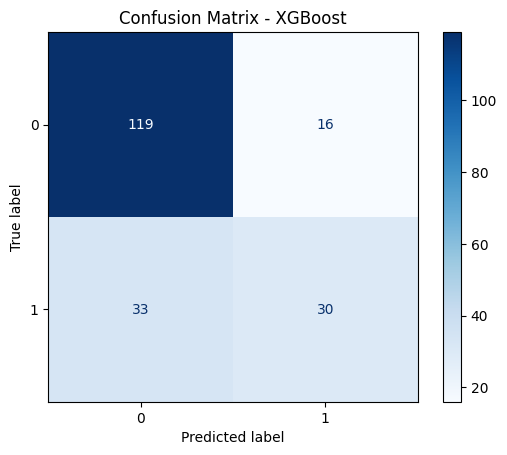

In [33]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()

The final XGBoost model achieves an overall accuracy of 75% on the held-out test set.

However, accuracy alone does not fully capture performance quality. A closer look at the classification report shows an important asymmetry:

- Class 0 (lower democracy rating) is predicted with strong performance:
  - Precision: 0.78
  - Recall: 0.88
  - F1-score: 0.83

- Class 1 (higher democracy rating) is harder for the model to identify:
  - Precision: 0.65
  - Recall: 0.48
  - F1-score: 0.55

This imbalance suggests that the model is considerably better at identifying respondents with lower democracy ratings than those with higher ratings.

The confusion matrix confirms this pattern:
- 119 true negatives were correctly classified.
- 30 true positives were correctly classified.
- 33 higher-rating respondents were misclassified as lower-rating.

From a modeling perspective, this indicates moderate class imbalance or overlapping feature distributions between groups.

For applied use, this means the model is more reliable in detecting skepticism toward democracy than in confidently identifying strong democratic support.

In [34]:
xgb_model = modelo_final.named_steps["estimator"]

feature_names = modelo_final.named_steps["select"].get_feature_names_out()

importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

importance_df.head(15)

,feature,importance
2,x237,0.597438
1,x236,0.168998
3,x242,0.135556
0,x188,0.098008


In [46]:
q_code_to_name = {
    'Q250': 'Importance_Democracy', # Target variable (for reference)
    'Q243': 'Trust_leaders', # From df_limpio rename
    'Q249': 'Women_Man_EqualRights', # From df_limpio rename
    'Q112': 'Corruption_Perception', # From df_limpio rename
    'Q237': 'Army_Rule', # From df_limpio rename
    'Q197': 'Government_rights', # From df_limpio rename
    'Q127': 'Poor_inmigration', # From df_limpio rename
    'Q262': 'Age', # From df_limpio rename
    # Previously identified important features from the original feature_importances:
    'Q188': 'Obedience_Importance',
    'Q236': 'Strong_Leader_Preference',
    'Q242': 'Trust_in_Press',
    # New features identified by SelectKBest for SHAP in current run:
    'Q189': 'Importance_Safety_Feeling', # Inferred: often related to feeling safe in WVS
    'Q238': 'Democracy_Direct_Laws' # Inferred: often related to direct democracy in WVS
}

print("Descriptive names for QXXX codes:")
for q_code, name in q_code_to_name.items():
    print(f"  {q_code}: {name}")

Descriptive names for QXXX codes:
  Q250: Importance_Democracy
  Q243: Trust_leaders
  Q249: Women_Man_EqualRights
  Q112: Corruption_Perception
  Q237: Army_Rule
  Q197: Government_rights
  Q127: Poor_inmigration
  Q262: Age
  Q188: Obedience_Importance
  Q236: Strong_Leader_Preference
  Q242: Trust_in_Press
  Q189: Importance_Safety_Feeling
  Q238: Democracy_Direct_Laws


In [47]:
feature_names_cleaned = [f.replace('x', 'Q') for f in feature_names]

importance_df_renamed = pd.DataFrame({
    "feature": feature_names_cleaned,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Map QXXX codes to descriptive names
importance_df_renamed["feature_description"] = importance_df_renamed["feature"].map(q_code_to_name)

# Top 15 features and their importances
print("Top 15 features with descriptive names:")
display(importance_df_renamed[['feature_description', 'importance']].head(15))

Top 15 features with descriptive names:


,feature_description,importance
2,Army_Rule,0.597438
1,Strong_Leader_Preference,0.168998
3,Trust_in_Press,0.135556
0,Obedience_Importance,0.098008


To understand which variables most influence predictions, we extracted feature importances from the trained XGBoost model.

The most influential features include:

- Army_Rule (Q237)
- Strong_Leader_Preference (Q236)
- Trust_in_Press (Q242)
- Obedience_Importance (Q188)

Notably, **Army_Rule** stands out with a substantially higher importance score (≈ 0.60), indicating that it carries a dominant share of the model's predictive power. This suggests that perceptions related to the acceptability of military rule play a central role in shaping attitudes toward the importance of democracy. Following this, the preference for a strong leader and trust in the press also exhibit significant influence.

While tree-based feature importance does not imply causality, it provides insight into which variables the model relies on most heavily when distinguishing between lower and higher democracy ratings.

For a deeper understanding, future extensions could include SHAP value analysis to examine directional effects and local interpretability at the individual prediction level.

# LIMITATIONS

- The analysis is observational and does not establish causal relationships.
- Survey responses may contain measurement bias.
- Cultural and country-level heterogeneity is not fully modeled in this version.
- Results depend on the chosen feature set and preprocessing decisions.

Future iterations could incorporate country fixed effects, multilevel modeling, or more advanced ensemble methods.

# <mark style="background:#FFF9C4"> MODEL SAVING

In [35]:
from joblib import dump
dump(modelo_final, "modelo_final_wvs.joblib", compress=("gzip", 9))

['modelo_final_wvs.joblib']

#SHAP ANALYSIS for Model Explainability

Add SHAP values to explain the predictions of the best-performing XGBoost model. Visualize global SHAP importances and, if feasible, a few local explanations, ensuring descriptive feature names are used in all SHAP plots.

In [50]:
# 2. Extract the xgb_model (estimator), preprocessor, and feature_selector from modelo_final pipeline
xgb_model = modelo_final.named_steps["estimator"]
preprocessor_step = modelo_final.named_steps["preprocessor"]
feature_selector_step = modelo_final.named_steps["select"]

# 3. Apply the preprocessor to X_train and X_test
X_train_preprocessed = preprocessor_step.fit_transform(X_train)
X_test_preprocessed = preprocessor_step.transform(X_test)

# Get feature names after preprocessing
# The preprocessor contains a ColumnTransformer with a 'num' transformer.
# The 'num' transformer has a pipeline which ends with StandardScaler.
# The FunctionTransformer in 'neg_to_nan' has feature_names_out='one-to-one', which means it preserves names.
# SimpleImputer does not change names. StandardScaler does not change names.
# So, the column names after preprocessing should be the original numeric_features.
preprocessed_feature_names = preprocessor_step.named_transformers_['num'].get_feature_names_out()

# Convert to DataFrame with correct column names
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=preprocessed_feature_names, index=X_train.index)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=preprocessed_feature_names, index=X_test.index)

# 4. Apply the feature_selector to the preprocessed X_train and X_test
# IMPORTANT: Do NOT refit feature_selector_step. It was already fitted as part of modelo_final.
# Just transform the preprocessed data.
X_train_selected_np = feature_selector_step.transform(X_train_preprocessed_df)
X_test_selected_np = feature_selector_step.transform(X_test_preprocessed_df)

# Get the names of the features that the modelo_final's SelectKBest *actually selected*.
# We use the 'feature_names' variable that was already correctly obtained in cell 4G5dNRYKi4wr
# and clean the 'x' prefix.
final_selected_q_codes = [f.replace('x', 'Q') for f in feature_names]

# Convert to DataFrame with the *correct* selected feature names
X_train_selected = pd.DataFrame(X_train_selected_np, columns=final_selected_q_codes, index=X_train.index)
X_test_selected = pd.DataFrame(X_test_selected_np, columns=final_selected_q_codes, index=X_test.index)

# 5. Create a shap.TreeExplainer instance
explainer = shap.TreeExplainer(xgb_model)

# 6. Compute SHAP values
shap_values_train = explainer.shap_values(X_train_selected)
shap_values_test = explainer.shap_values(X_test_selected)

# 7. Create a dictionary to map QXXX codes to descriptive names for selected features
# Use the q_code_to_name dictionary defined earlier.
selected_feature_names_list = final_selected_q_codes # This now correctly holds the Q-codes
mapped_feature_names = {f: q_code_to_name.get(f, f)
                        for f in selected_feature_names_list}

# Also create a list of mapped names in the correct order for plotting
mapped_feature_names_for_plot = [mapped_feature_names[f] for f in selected_feature_names_list]

print("SHAP analysis setup complete. Explainer and SHAP values computed.")
print("Mapped feature names for selected features:", mapped_feature_names_for_plot)


SHAP analysis setup complete. Explainer and SHAP values computed.
Mapped feature names for selected features: ['Obedience_Importance', 'Strong_Leader_Preference', 'Army_Rule', 'Trust_in_Press']


Generating SHAP Summary Plot...


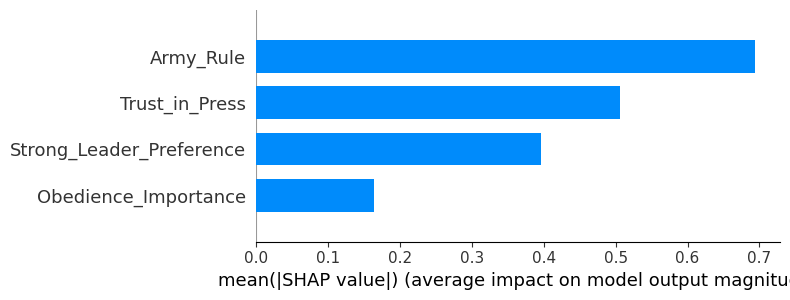

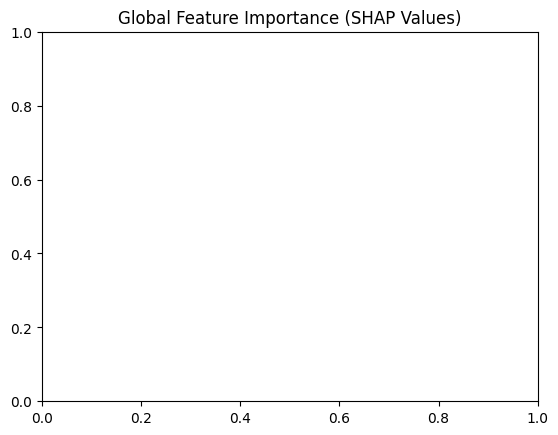

Generating SHAP Beeswarm Plot...


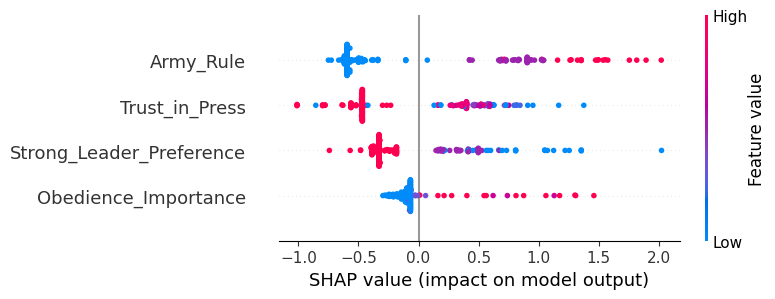

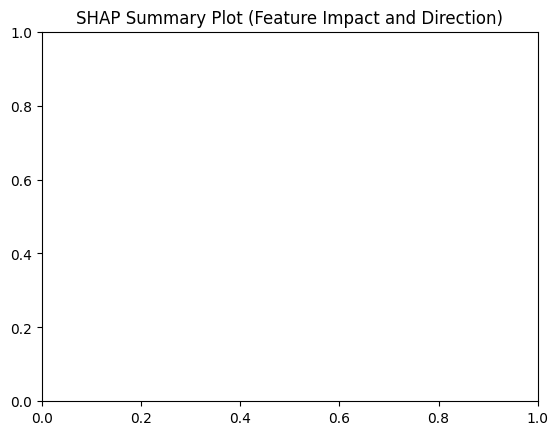

Generating SHAP Force Plots for individual predictions...
Force plot for test instance 0:


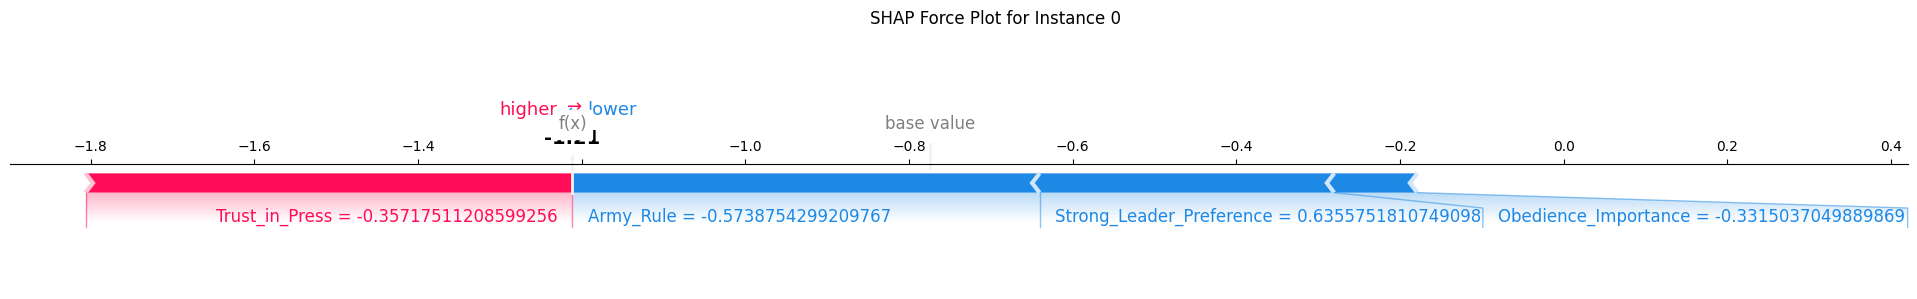

Force plot for test instance 1:


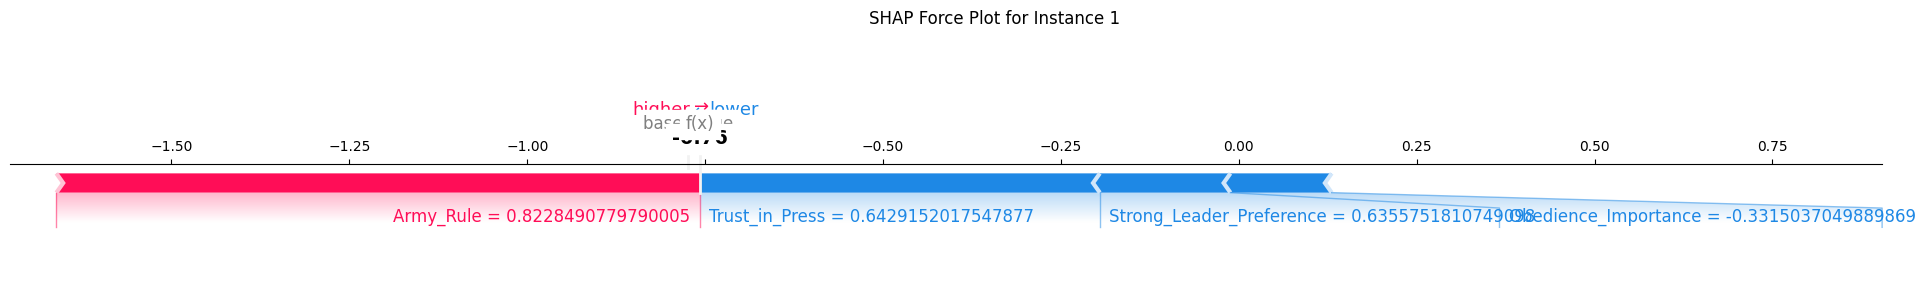

Force plot for test instance 2:


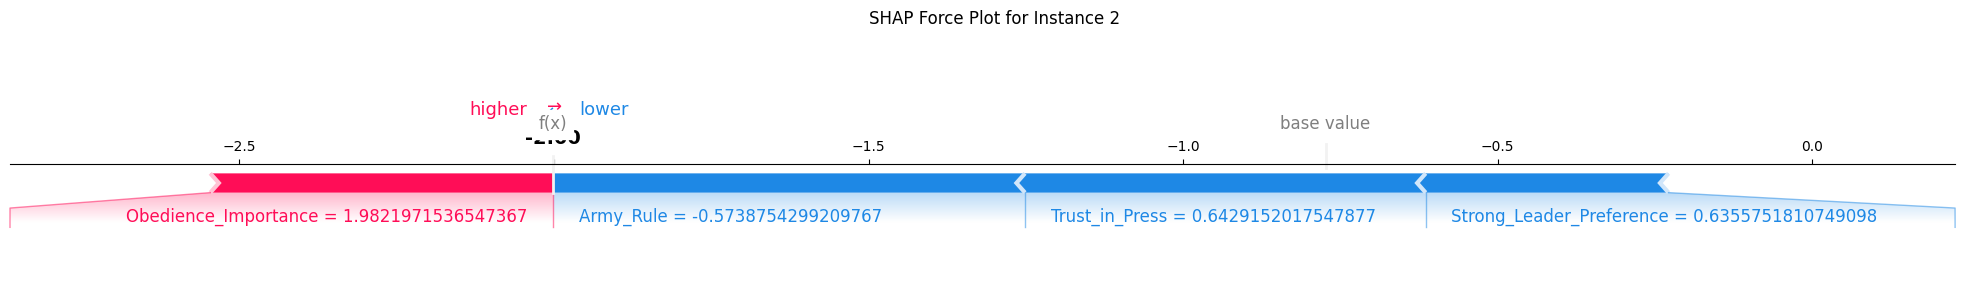

In [59]:
# 8. Generate a SHAP summary plot to show global feature importance.
# We need to pass the actual feature names (QXXX) to the `feature_names` parameter of shap.summary_plot
# to ensure correct mapping from `X_test_selected` to the mapped_feature_names.

# Create a dictionary to map selected_feature_names_list (like 'x188') to descriptive names
display_feature_names = {f: q_code_to_name.get(f.replace('x', 'Q'), f.replace('x', 'Q')) for f in selected_feature_names_list}

print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_values_test, X_test_selected, feature_names=[display_feature_names[col] for col in X_test_selected.columns], plot_type="bar")
plt.title("Global Feature Importance (SHAP Values)")
plt.show()
plt.close() # Close the figure after showing

# For the dot plot (beeswarm), it's good to see distribution
print("Generating SHAP Beeswarm Plot...")
shap.summary_plot(shap_values_test, X_test_selected, feature_names=[display_feature_names[col] for col in X_test_selected.columns])
plt.title("SHAP Summary Plot (Feature Impact and Direction)")
plt.show()
plt.close() # Close the figure after showing

# 9. Generate SHAP force plots for a few selected instances from the test set
print("Generating SHAP Force Plots for individual predictions...")
# Select a few instances from the test set for local explanations
num_instances_to_explain = 3

for i in range(num_instances_to_explain):
    print(f"Force plot for test instance {i}:")
    # shap.force_plot with matplotlib=True returns a matplotlib Figure object.
    # By passing show=False, we explicitly prevent shap from calling plt.show() internally.
    fig = shap.force_plot(explainer.expected_value, shap_values_test[i], X_test_selected.iloc[i],
                    feature_names=[display_feature_names[col] for col in X_test_selected.columns], matplotlib=True, show=False)

    # Add a title to the figure
    if hasattr(fig, 'suptitle'):
        fig.suptitle(f"SHAP Force Plot for Instance {i}", fontsize=12)

    # Now, explicitly show the figure and then close it.
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show(fig) # Display the specific figure
    plt.close(fig) # Close the figure to prevent display issues in subsequent iterations